**Autorzy:** Łukasz Stachowicz, Błażej Domagała, Michał Dobosz

**Grupa:** 1

**Prowadzący:** Marek Szyndler

**Temat projektu:** Zbudować oprogramowanie z wykorzystaniem bibliotek Pcap/winpcap itp. umożliwiające badanie działania przeglądarek internetowych, w tym umożliwiające określenie liczby równocześnie pobieranych plików, pokazanie na wykresie czasu pobierania całej strony i poszczególnych obiektów, określenie przerwy czasowej w pobieraniu poszczególnych plików w ramach pojedynczego połączenia.

## Stanowisko badawcze

Badanie zostało przeprowadzone w następującej konfiguracji:

**Komputer kliencki (Linux):**
- System operacyjny: Linux
- Funkcja: przechwytywanie pakietów sieciowych (pcap), uruchamianie testowanych przeglądarek internetowych
- Połączenie: kabel Ethernet do routera

**Router:**
- Funkcja: przekazywanie ruchu sieciowego między komputerem klienckim a serwerem

**Komputer serwerowy (macOS):**
- System operacyjny: macOS
- Połączenie: kabel Ethernet do routera
- Serwer HTTP: Nginx uruchomiony w kontenerze Docker
- Funkcja: hosting strony WWW do testowania

**Topologia sieci:** Komputer Linux ⟷ Router ⟷ Komputer macOS (połączenia: Ethernet)

## Zakres pracy

**1. Serwer WWW**
- Przygotowanie środowiska serwera HTTP w kontenerze Docker (nginx)
- Serwer udostępnia 92 pliki graficzne (JPEG), każdy o wielkości ok. 20 MB – są to kolejne obroty tego samego obrazka
- Automatyczne generowanie obrazów podczas budowania kontenera
- Ważne elementy konfiguracji nginx:
    - Wyłączenie obsługi żądań częściowych (Range/If-Range) dla obrazów (`Accept-Ranges none`, `max_ranges 0`, `etag off`)
    - Wymuszenie pełnych odpowiedzi 200 dla obrazów niezależnie od żądania klienta
    - Ustawienie nagłówków Cache-Control i Pragma na brak cache dla obrazów
    - Krótkie cache dla index.html, dłuższe dla CSS/JS
    - Włączenie autoindeksowania katalogu `/images/` (lista plików)
    - Wszystkie pliki graficzne serwowane są z katalogu `/usr/share/nginx/html/images/`

**2. Oprogramowanie do przechwytywania ruchu sieciowego**
- Stworzenie własnego sniffera HTTP na bazie libpcap w języku C++
- Program analizuje ruch na porcie TCP 80, rejestruje znaczniki czasu, adresy źródłowe i docelowe, porty oraz pierwszą linię żądania/odpowiedzi HTTP
- Obsługa filtrów BPF, wybór interfejsu sieciowego, możliwość ograniczenia liczby przechwytywanych pakietów
- Eksport danych do pliku CSV do dalszej analizy

**3. Oprogramowanie do analizy danych z ruchu sieciowego**
- Wczytanie i przygotowanie danych z pliku CSV (przechwycone pakiety HTTP)
- Grupowanie według przeglądarki i próby, obliczenie liczby pobranych obiektów (całościowo i dla obiektów ≥ 1 MB)
- Analiza rozkładu silników renderujących, czasu ładowania strony, liczby równoczesnych pobrań, rozkładu procentowego aktywnych downloadów
- Wizualizacja przebiegu pobierania obiektów (wykres Gantta), czasu i prędkości pobierania, przerw czasowych (gaps)
- Wszystkie wykresy i statystyki przygotowane z użyciem pandas, seaborn, matplotlib
- Opisy i komunikaty w języku polskim

Projekt umożliwia kompleksową ocenę zachowania przeglądarek podczas pobierania strony WWW oraz jej zasobów, z uwzględnieniem wydajności, równoległości i efektywności transferu danych.


In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 5)


W tej części pracy następuje wczytanie danych z pliku CSV, który zawiera przechwycone pakiety HTTP z testów przeglądarek. Dane są wstępnie przetwarzane: sprawdzana jest ich kompletność, konwertowane są typy, dodawane są pomocnicze kolumny (np. rozmiar, czas trwania, prędkość pobierania), a także identyfikowany jest silnik renderujący każdej przeglądarki. Tak przygotowany zbiór danych stanowi podstawę do dalszych analiz i wizualizacji opisujących zachowanie przeglądarek podczas pobierania zasobów strony WWW.

In [154]:
csv_path = "content/output.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"File not found: {csv_path}")

df = pd.read_csv(csv_path)

required = [
    'first_timestamp_ms',
    'last_timestamp_ms',
    'duration_ms',
    'total_bytes',
    'request_uri',
    'client_port'
 ]
missing = [col for col in required if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {', '.join(missing)}")

df['first_timestamp'] = pd.to_datetime(df['first_timestamp_ms'], unit='ms', utc=True)
df['last_timestamp'] = pd.to_datetime(df['last_timestamp_ms'], unit='ms', utc=True)
df['duration_ms'] = df['duration_ms'].astype(float)
df['total_bytes'] = df['total_bytes'].astype(float)

if 'completion_percent' in df.columns:
    df['completion_percent'] = df['completion_percent'].astype(float)
    completion_ok = df['completion_percent'] == 100.0
    df_complete = df[completion_ok].copy()
else:
    print("No 'completion_percent' column – assuming all rows are complete.")
    df['completion_percent'] = np.nan
    df_complete = df.copy()

df_complete['size_kb'] = df_complete['total_bytes'] / 1024.0
df_complete['duration_s'] = df_complete['duration_ms'] / 1000.0
df_complete['speed_kb_per_s'] = df_complete['size_kb'] / df_complete['duration_s'].replace(0, np.nan)

def detect_engine(browser_name):
    """Mapuje nazwę przeglądarki na silnik renderujący."""
    browser_lower = browser_name.lower()
    if browser_lower in ['chrome', 'brave', 'edge', 'opera']:
        return 'Blink'
    elif browser_lower == 'firefox':
        return 'Gecko'
    elif browser_lower == 'safari' or browser_lower == 'epiphany':
        return 'WebKit'
    else:
        return 'Inny'

df_complete['engine'] = df_complete['browser'].apply(detect_engine)
df_complete['browser_attempt'] = df_complete['browser'] + ' ' + df_complete['attempt'].astype(str)


# 1. Ogólne statystyki

### Podstawowe statystyki wczytanych danych
Poniżej prezentowane są ogólne statystyki dotyczące liczby wszystkich wczytanych wierszy oraz liczby kompletnych rekordów (100% ukończenia). Te informacje pozwalają ocenić jakość i kompletność danych przed dalszą analizą.

W dalszych analizach skupiamy się na obiektach o wielkości co najmniej 1 MB, ponieważ interesuje nas wydajność pobierania dużych plików graficznych (obrazków), które w testach mają właśnie rozmiar powyżej 1 MB. Takie podejście pozwala lepiej porównać zachowanie przeglądarek przy pobieraniu zasobów o istotnej wielkości, eliminując wpływ drobnych plików.

Jeśli w którejkolwiek analizie będą brane pod uwagę wszystkie obiekty (nie tylko te powyżej 1 MB), zostanie to wyraźnie zaznaczone w opisie danej sekcji lub wykresu.

In [155]:
ONE_MB = 1024 * 1024
df_large = df_complete[df_complete['total_bytes'] >= ONE_MB].copy()

print(f"\nWczytano wierszy: {len(df)}")
print(f"Kompletne wiersze (100% ukończenia): {len(df_complete)}")

print(f"\nPrzeanalizowano obiektów >= 1 MB: {len(df_large)}")
print("\nLiczba obiektów >= 1 MB według przeglądarki i próby:")
obj_counts = df_large.groupby(['browser', 'attempt']).size().reset_index(name='Liczba')
display(obj_counts)



Wczytano wierszy: 1394
Kompletne wiersze (100% ukończenia): 1394

Przeanalizowano obiektów >= 1 MB: 1380

Liczba obiektów >= 1 MB według przeglądarki i próby:


,browser,attempt,Liczba
0,Brave,1,92
1,Brave,2,92
2,Brave,3,92
3,Chrome,1,92
4,Chrome,2,92
5,Chrome,3,92
6,Epiphany,1,92
7,Epiphany,2,92
8,Epiphany,3,92
9,Firefox,1,92


#### Rozkład silników przeglądarek
W tej sekcji analizujemy rozkład dużych obiektów (>= 1 MB) ze względu na silnik renderujący przeglądarki. Przeglądarki są pogrupowane według używanego silnika (np. Blink, Gecko, WebKit), ponieważ oczekujemy, że przeglądarki korzystające z tego samego silnika będą wykazywać podobne zachowanie podczas pobierania dużych plików. Pozwoli to lepiej zrozumieć wpływ technologii renderowania na wydajność pobierania zasobów.


Ilość dużych obiektów (>= 1 MB) przeanalizowanych dla każdego z silników przeglądarek:
engine
Blink     828
WebKit    276
Gecko     276
Name: count, dtype: int64


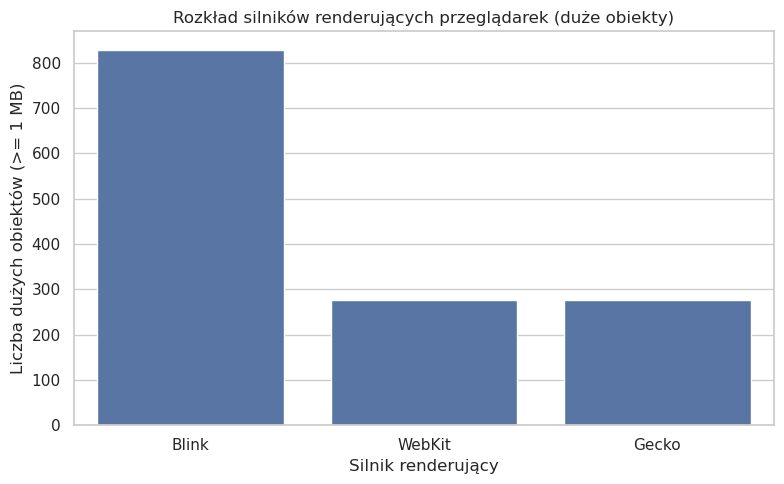

In [156]:
print("\nIlość dużych obiektów (>= 1 MB) przeanalizowanych dla każdego z silników przeglądarek:")
print(df_large['engine'].value_counts())

plt.figure(figsize=(8, 5))
engine_counts = df_large['engine'].value_counts()
sns.barplot(x=engine_counts.index, y=engine_counts.values)
plt.xlabel('Silnik renderujący')
plt.ylabel('Liczba dużych obiektów (>= 1 MB)')
plt.title('Rozkład silników renderujących przeglądarek (duże obiekty)')
plt.tight_layout()
plt.show()


# 2. Analiza całej strony
W tej części skupiamy się na analizie procesu ładowania całej strony WWW przez różne przeglądarki. Interesuje nas, jak długo trwa pobranie wszystkich zasobów strony w ramach jednej próby oraz jak przebiega rozkład aktywnych pobrań w czasie. Badamy także liczbę równoczesnych downloadów, procentowy rozkład aktywności oraz wizualizujemy przebieg pobierania obiektów na wykresie Gantta. Pozwoli to ocenić wydajność i strategię pobierania zasobów przez różne przeglądarki oraz zidentyfikować ewentualne różnice w sposobie zarządzania połączeniami i równoległością transferów.

W tej analizie wykorzystujemy wszystkie pobrane obiekty (nie tylko duże pliki powyżej 1 MB), aby uzyskać pełny obraz procesu ładowania strony i aktywności sieciowej.

Wyniki tej analizy są kluczowe dla zrozumienia, które przeglądarki efektywniej wykorzystują dostępne połączenia i szybciej pobierają całą stronę, a także jak rozkłada się obciążenie sieci w czasie ładowania.

,browser,attempt,browser_attempt,total_page_load_time_ms,total_page_load_time_s,objects_count,total_bytes_mb
0,Brave,1,Brave 1,72090.0,72.090,94,1971.989051
1,Brave,2,Brave 2,66324.0,66.324,93,1971.987244
2,Brave,3,Brave 3,62221.0,62.221,92,1971.986714
3,Chrome,1,Chrome 1,73103.0,73.103,92,1971.986714
4,Chrome,2,Chrome 2,61588.0,61.588,93,1971.987244
5,Chrome,3,Chrome 3,60661.0,60.661,93,1971.987244
6,Epiphany,1,Epiphany 1,53506.0,53.506,94,1971.988667
7,Epiphany,2,Epiphany 2,60325.0,60.325,94,1971.988667
8,Epiphany,3,Epiphany 3,53377.0,53.377,94,1971.988667
9,Firefox,1,Firefox 1,69013.0,69.013,92,1971.986714


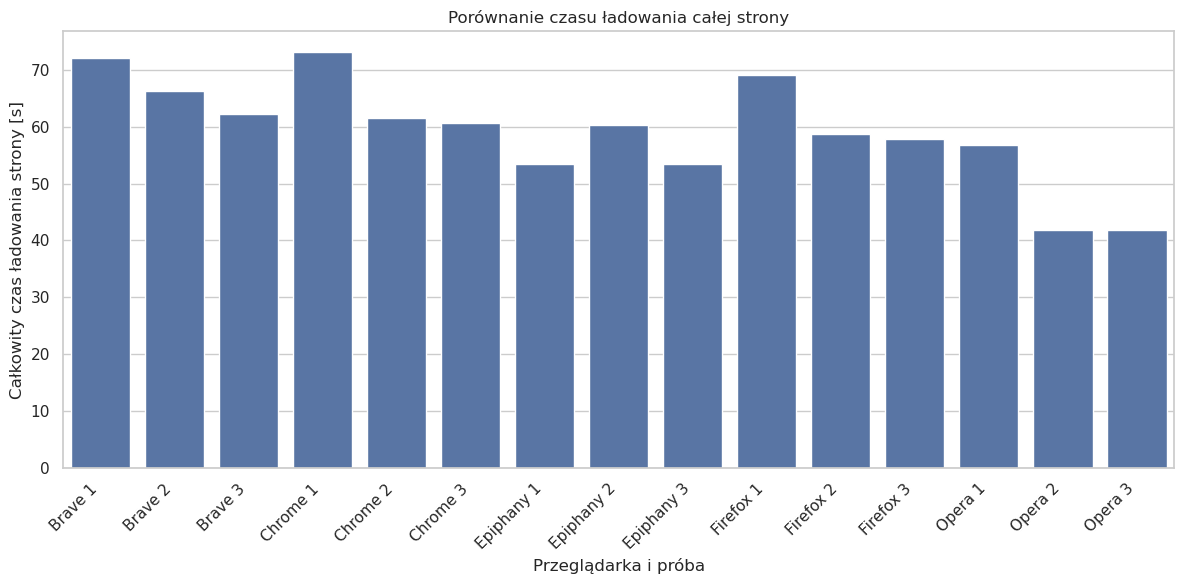

In [157]:
page_load_times = []
for (b, a), g in df_complete.groupby(['browser', 'attempt']):
    total_time_ms = (g['last_timestamp'].max() - g['first_timestamp'].min()).total_seconds() * 1000
    page_load_times.append({
        'browser': b,
        'attempt': a,
        'browser_attempt': f'{b} {a}',
        'total_page_load_time_ms': total_time_ms,
        'total_page_load_time_s': total_time_ms / 1000,
        'objects_count': len(g),
        'total_bytes_mb': g['total_bytes'].sum() / (1024 * 1024)
    })

page_load_df = pd.DataFrame(page_load_times)
display(page_load_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=page_load_df, x='browser_attempt', y='total_page_load_time_s')
plt.xlabel('Przeglądarka i próba')
plt.ylabel('Całkowity czas ładowania strony [s]')
plt.title('Porównanie czasu ładowania całej strony')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Liczba równoczesnych pobrań w czasie
Na poniższym wykresie chcemy zobaczyć, jak zmienia się liczba aktywnych pobrań obiektów w czasie dla każdej przeglądarki i każdej próby. Wykres pozwala ocenić, jak przeglądarki zarządzają równoległością transferów podczas ładowania strony – czy pobierają wiele plików jednocześnie, czy raczej sekwencyjnie. Linie na wykresie pokazują przebieg dla każdej próby osobno, co umożliwia porównanie strategii pobierania pomiędzy przeglądarkami oraz pomiędzy kolejnymi uruchomieniami testu.

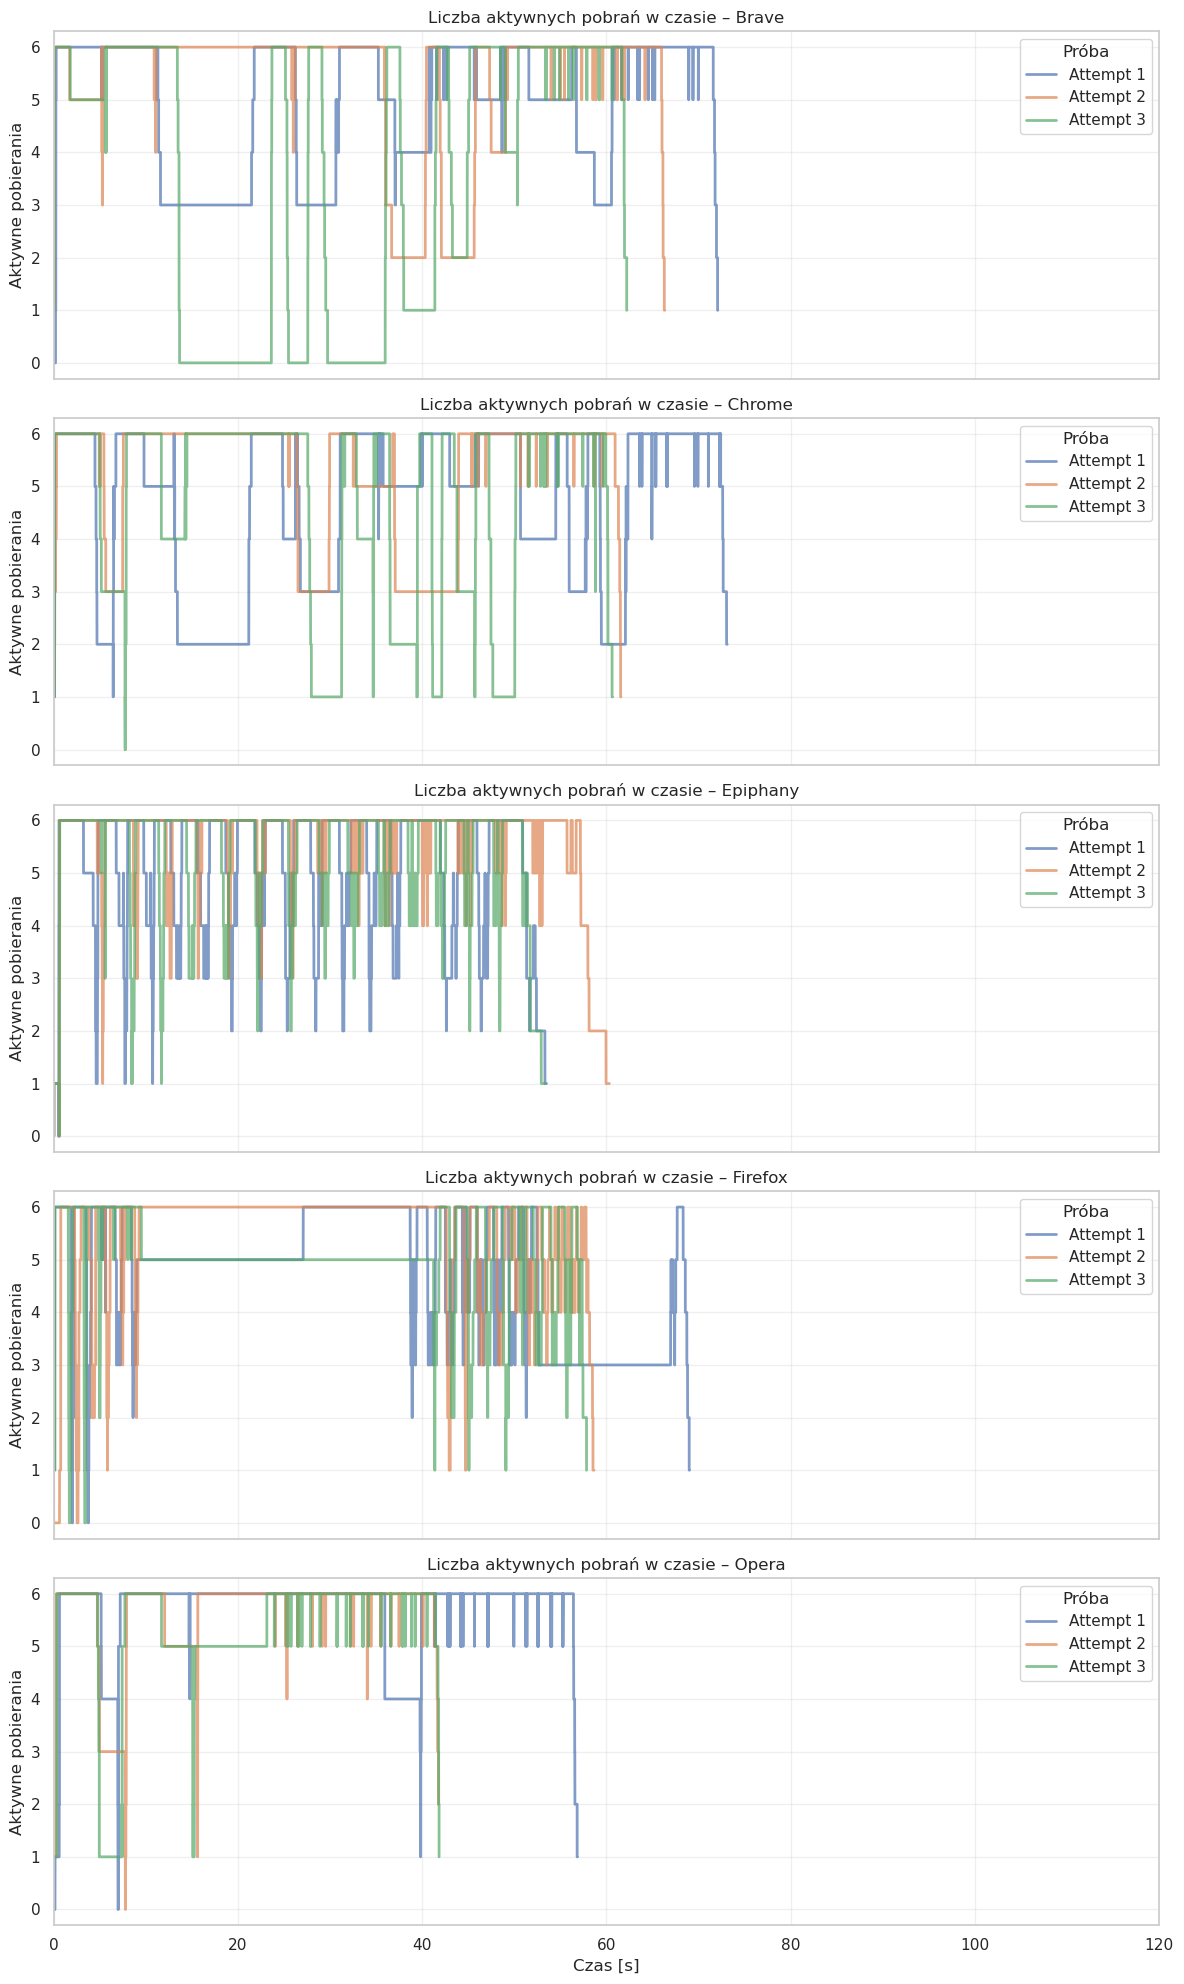

In [158]:
def active_downloads(df_sub, max_time_s=120):
    if df_sub.empty:
        return np.array([]), np.array([])
    t0 = df_sub['first_timestamp'].min()
    tend = df_sub['last_timestamp'].max()
    freq = '10ms'
    ts_all = pd.date_range(t0, tend, freq=freq)
    rel_time = (ts_all - t0).total_seconds()
    rel_time = rel_time[rel_time <= max_time_s]
    ts_all = ts_all[:len(rel_time)]

    active_counts = []
    starts = df_sub['first_timestamp']
    ends = df_sub['last_timestamp']
    for t in ts_all:
        active_counts.append(((starts <= t) & (ends >= t)).sum())
    return rel_time, np.array(active_counts)

browsers = sorted(df_complete['browser'].unique())
n_browsers = len(browsers)

if n_browsers > 0:
    fig, axes = plt.subplots(n_browsers, 1, sharex=True, figsize=(12, 4 * n_browsers))
    if n_browsers == 1:
        axes = [axes]

    for ax, browser in zip(axes, browsers):
        browser_data = df_complete[df_complete['browser'] == browser]
        attempts = sorted(browser_data['attempt'].unique())

        for attempt in attempts:
            g = browser_data[browser_data['attempt'] == attempt]
            xs, ys = active_downloads(g)
            if len(xs) > 0:
                ax.plot(xs, ys, drawstyle='steps-post', label=f'Attempt {attempt}', linewidth=2, alpha=0.7)

        ax.set_ylabel('Aktywne pobierania')
        ax.set_title(f'Liczba aktywnych pobrań w czasie – {browser.capitalize()}')
        ax.set_xlim(0, 120)
        ax.legend(loc='upper right', title='Próba')
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel('Czas [s]')
    plt.tight_layout()
    plt.show()
else:
    print("Nie wykryto przeglądarek – nie można narysować wykresu.")


### Procentowy rozkład liczby równoczesnych pobrań – interpretacja
Na poniższym wykresie zobaczymy, jaki procent czasu podczas ładowania strony przeglądarki utrzymują określoną liczbę równoczesnych pobrań obiektów. Każdy słupek pokazuje, jak często (procentowo) dana przeglądarka pobierała jednocześnie 1, 2, 3 itd. pliki.
Wizualizacja pozwala porównać strategie równoległego pobierania zasobów przez różne przeglądarki. Im wyższy słupek przy większej liczbie równoczesnych pobrań, tym bardziej przeglądarka wykorzystuje równoległość transferów, co może przekładać się na szybsze ładowanie strony.


Rozkład liczby równoczesnych pobrań (% czasu):


,active,dt,percent,browser,attempt
0,0,0.200,0.277431,Brave,1
1,1,0.082,0.113747,Brave,1
2,2,0.129,0.178943,Brave,1
3,3,16.221,22.501040,Brave,1
4,4,6.266,8.691913,Brave,1
...,...,...,...,...,...
96,2,0.153,0.365618,Opera,3
97,3,0.085,0.203121,Opera,3
98,4,0.208,0.497049,Opera,3
99,5,12.131,28.988936,Opera,3


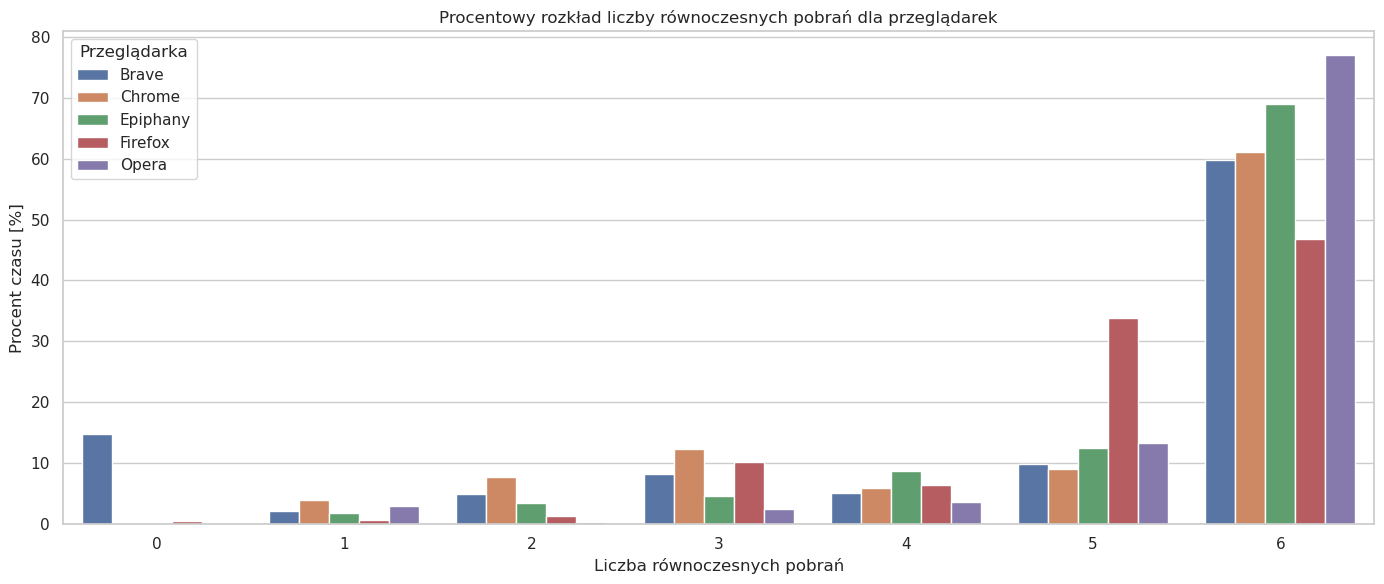

In [159]:
def active_distribution(df_sub):
    if df_sub.empty:
        return pd.DataFrame(columns=['active', 'dt', 'percent'])

    events = []
    for s, e in zip(df_sub['first_timestamp'], df_sub['last_timestamp']):
        events.append((s, +1))
        events.append((e, -1))
    events.sort()

    active = 0
    last_t = events[0][0]
    spans = []

    for t, delta in events:
        if t > last_t:
            spans.append({
                'active': active,
                'dt': (t - last_t).total_seconds()
            })
        active += delta
        last_t = t

    dist = pd.DataFrame(spans).groupby('active', as_index=False)['dt'].sum()
    total = dist['dt'].sum()
    dist['percent'] = 100 * dist['dt'] / total if total > 0 else 0.0
    return dist

dist_all = []
for (b, a), g in df_complete.groupby(['browser', 'attempt']):
    d = active_distribution(g)
    d['browser'] = b
    d['attempt'] = a
    dist_all.append(d)

if dist_all:
    dist_all = pd.concat(dist_all, ignore_index=True)
    print("\nRozkład liczby równoczesnych pobrań (% czasu):")
    display(dist_all)

    plt.figure(figsize=(14, 6))
    sns.barplot(data=dist_all, x='active', y='percent', hue='browser', errorbar=None)
    plt.xlabel('Liczba równoczesnych pobrań')
    plt.ylabel('Procent czasu [%]')
    plt.title('Procentowy rozkład liczby równoczesnych pobrań dla przeglądarek')
    plt.legend(title='Przeglądarka')
    plt.tight_layout()
    plt.show()
else:
    print("Brak danych do analizy rozkładu aktywnych pobrań.")


### Wykresy Gantta – interpretacja
Na poniższych wykresach Gantta dla każdej przeglądarki i każdej próby zobaczymy szczegółowy przebieg pobierania obiektów przez różne połączenia (porty klienta).
Każdy poziomy pasek odpowiada jednemu połączeniu TCP (portowi klienta) i pokazuje, kiedy w ramach tego połączenia pobierane były poszczególne pliki. Długość paska odzwierciedla czas pobierania danego obiektu.
Wykres pozwala zobaczyć:
- ile połączeń równolegle wykorzystuje przeglądarka podczas ładowania strony,
- czy pobieranie plików odbywa się sekwencyjnie czy równolegle,
- czy występują przerwy pomiędzy pobieraniem kolejnych obiektów na tym samym połączeniu,
- jak rozkłada się obciążenie sieci w czasie ładowania strony.
Dzięki temu można porównać strategie zarządzania połączeniami i równoległością transferów pomiędzy przeglądarkami oraz pomiędzy kolejnymi próbami.

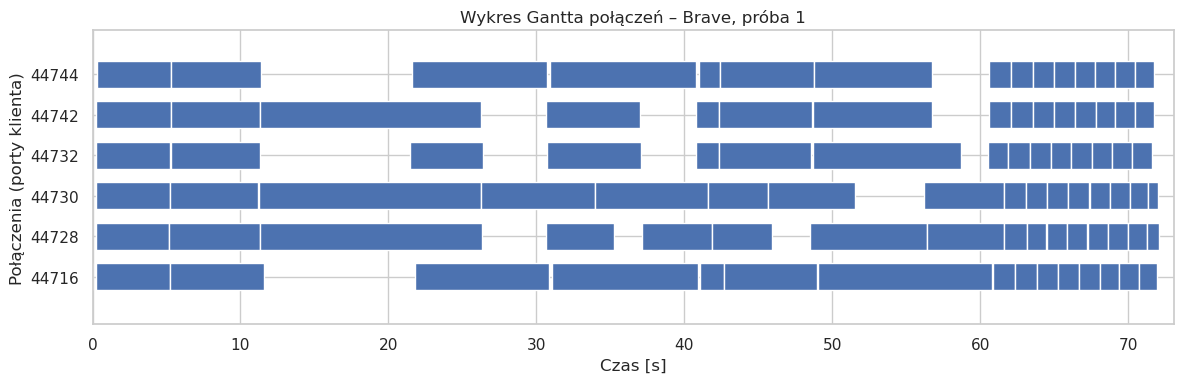

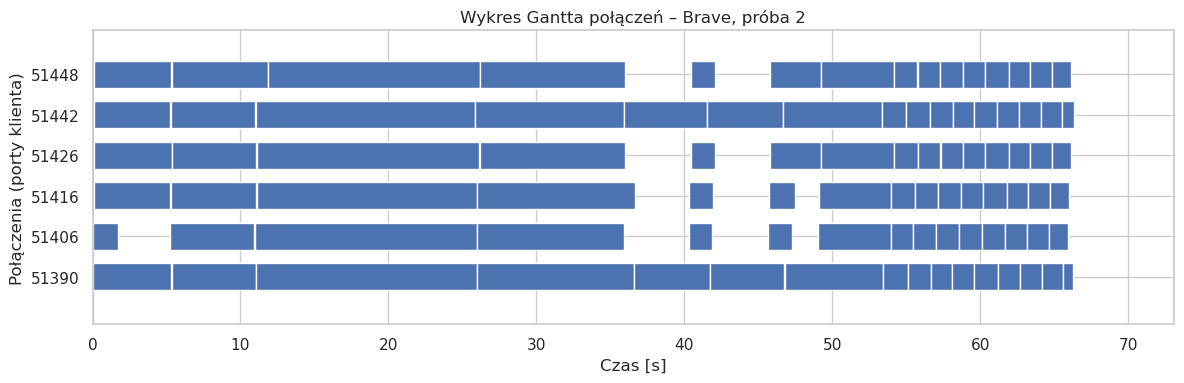

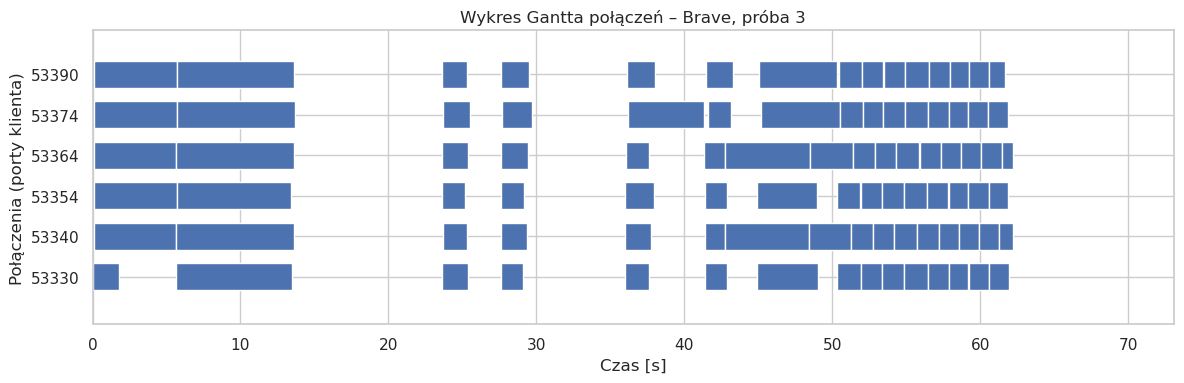

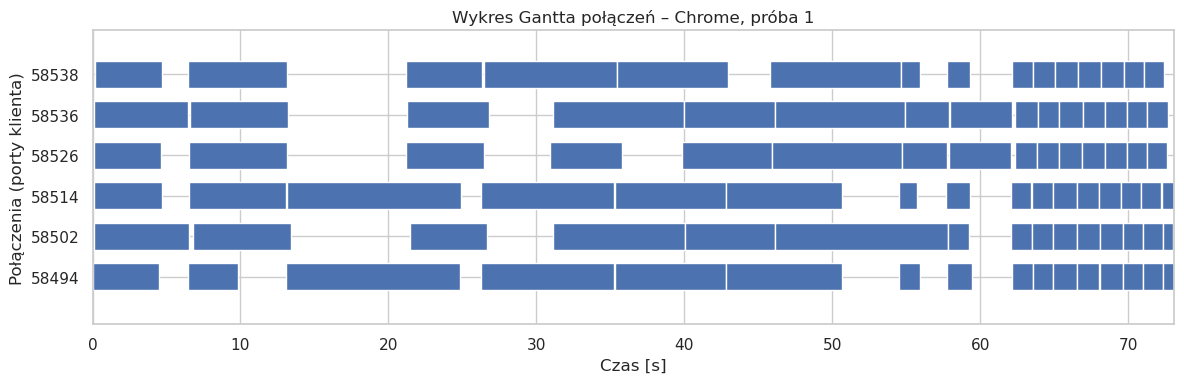

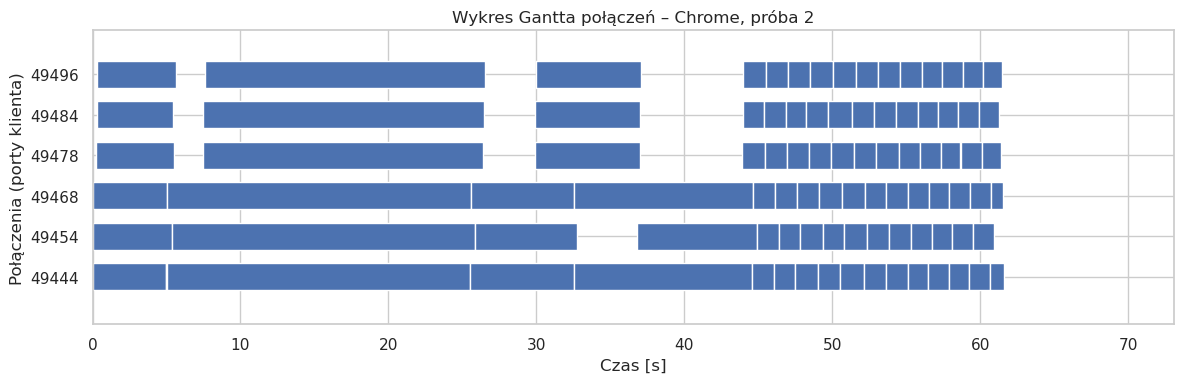

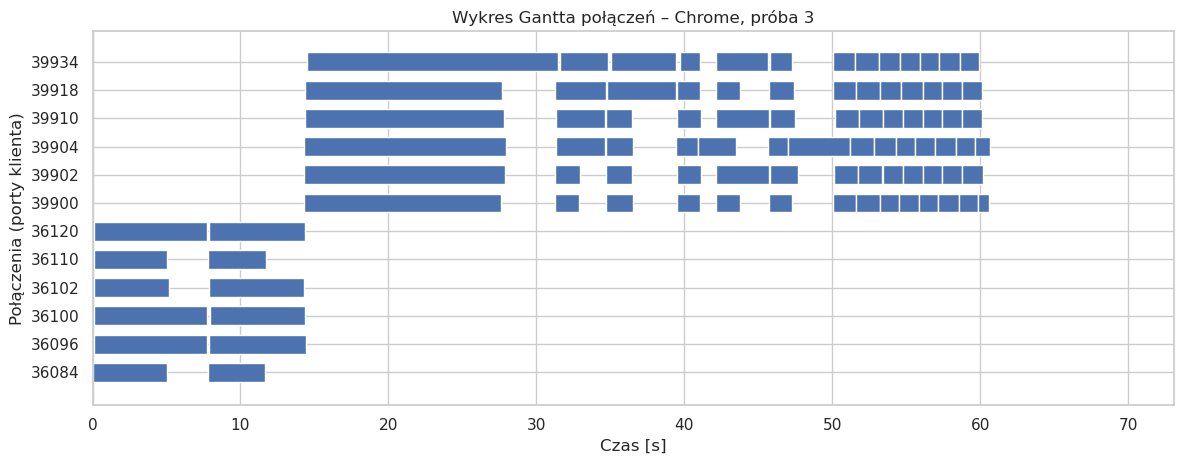

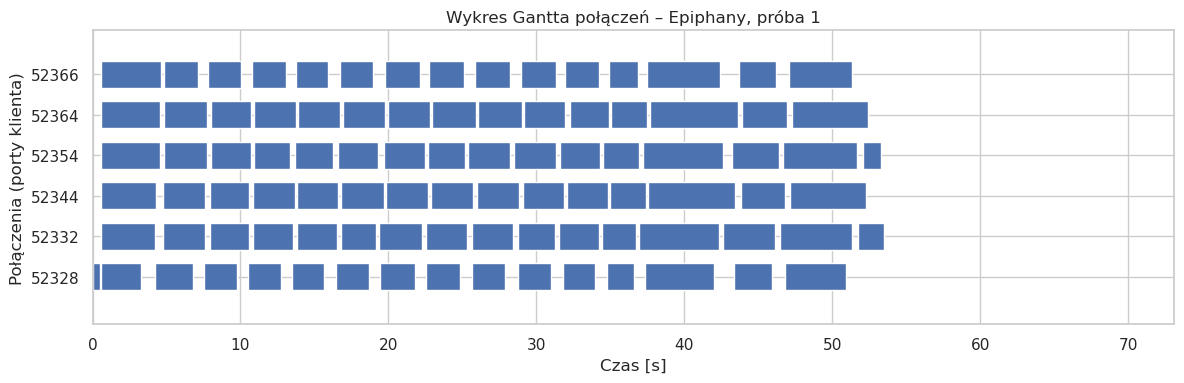

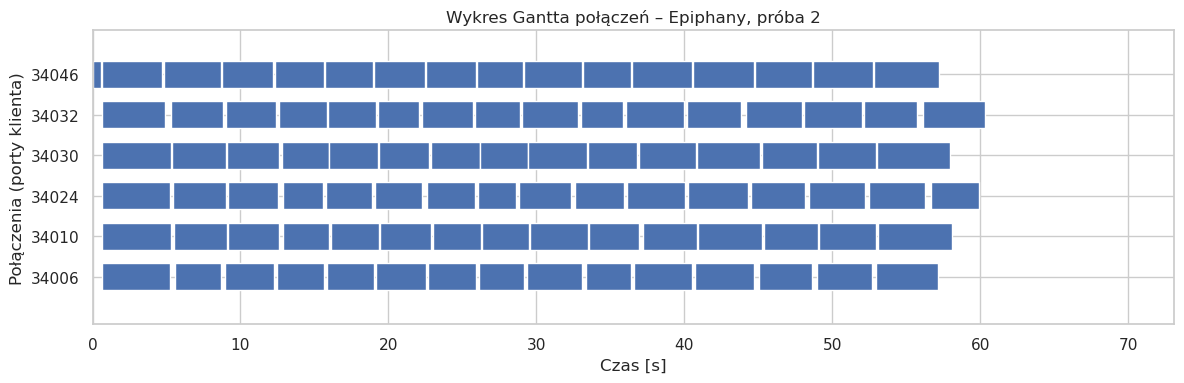

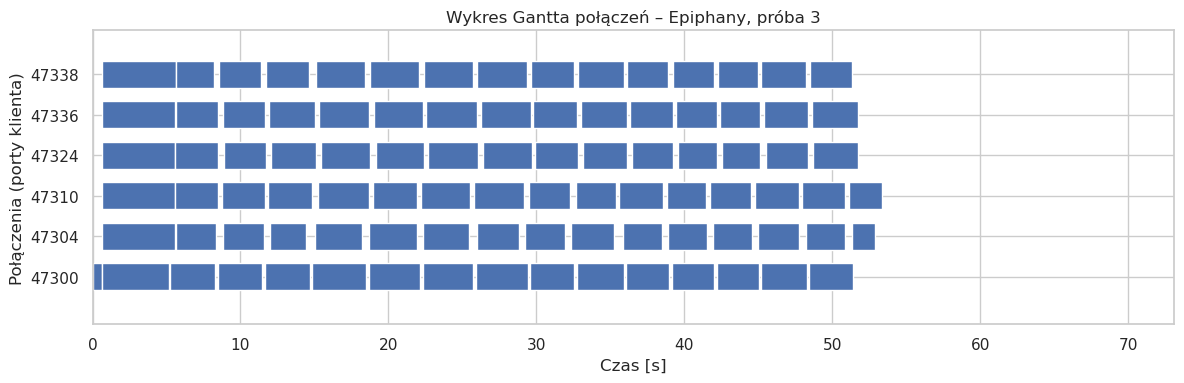

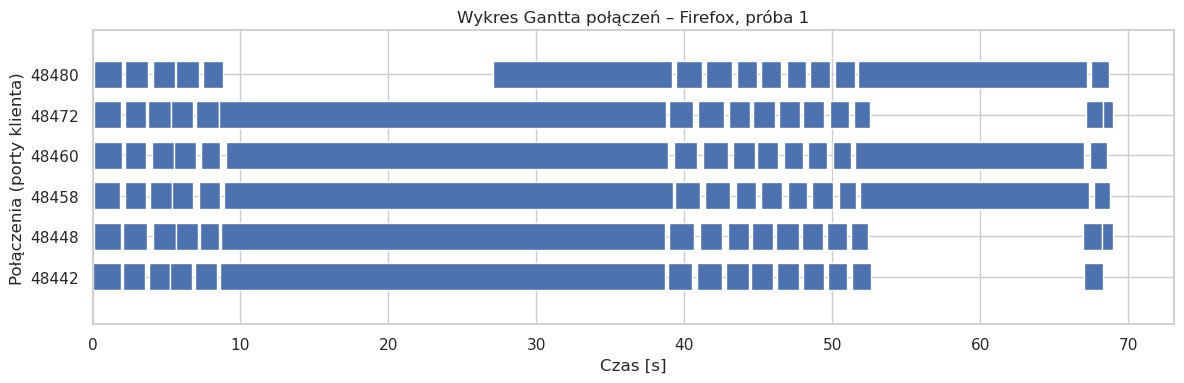

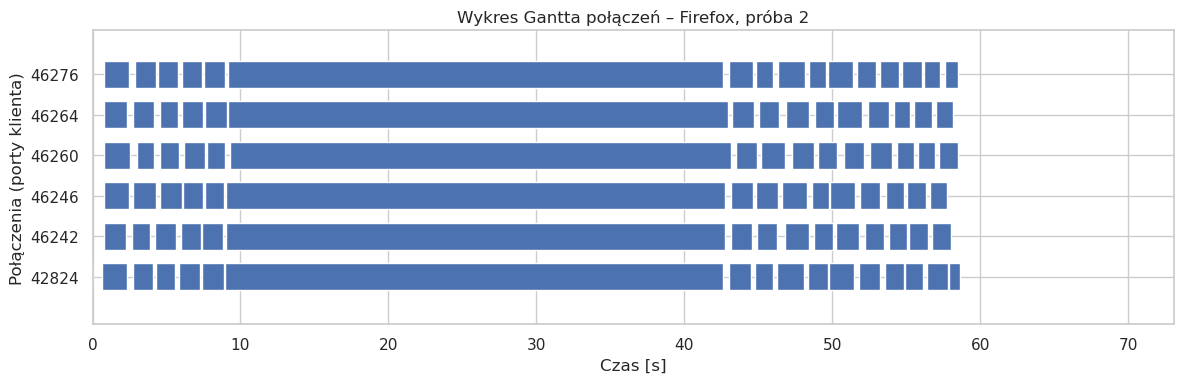

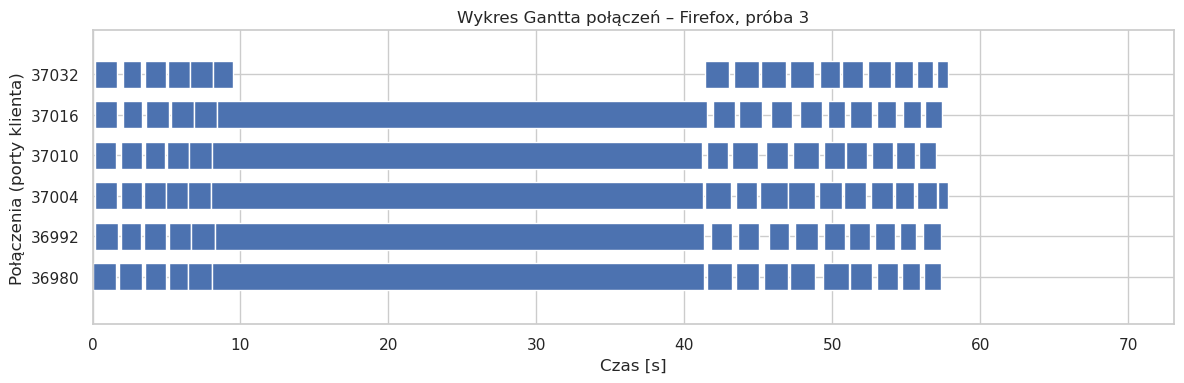

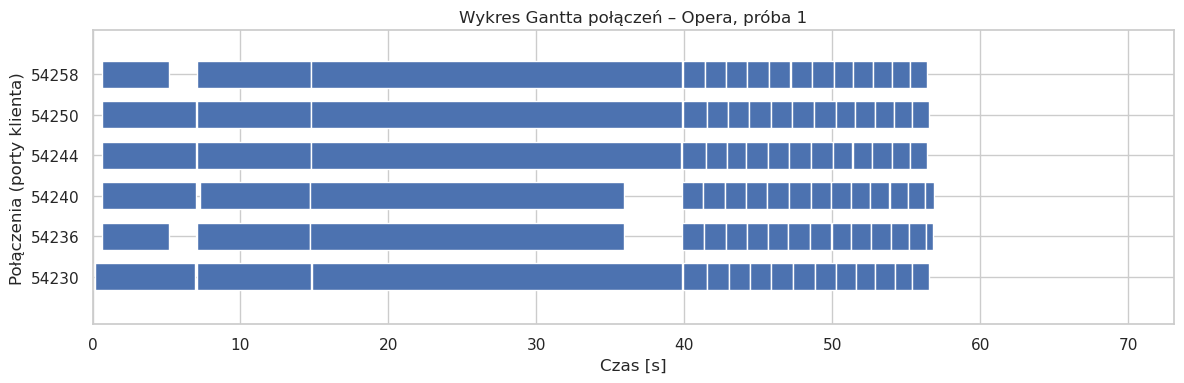

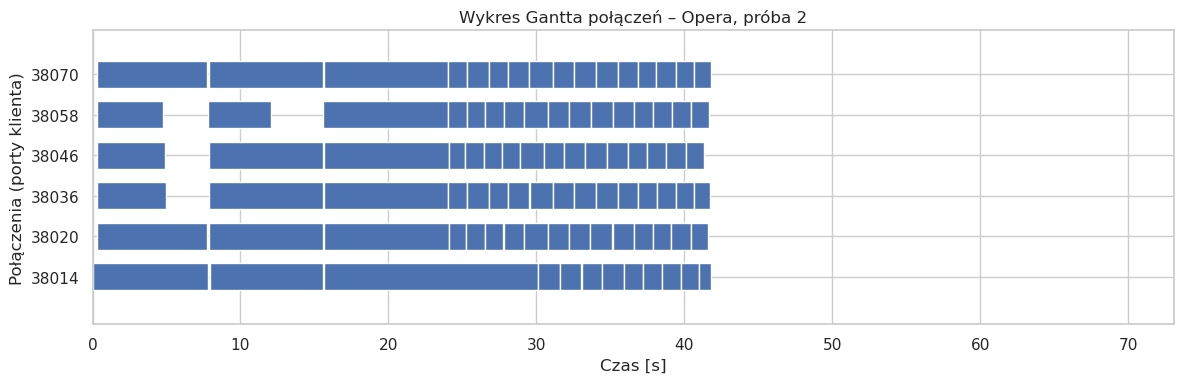

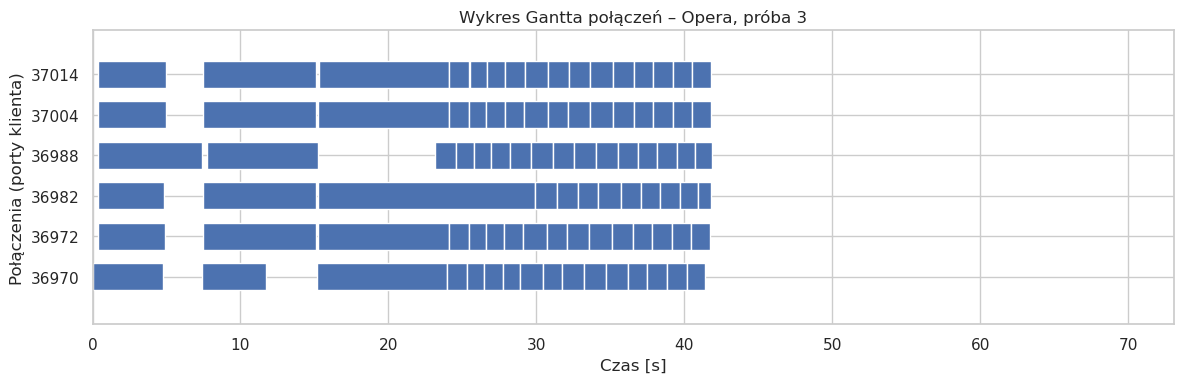

In [160]:
df_gantt = df_complete.copy()
df_gantt['order_in_port'] = (
    df_gantt.sort_values('first_timestamp')
    .groupby(['browser', 'attempt', 'client_port'])
    .cumcount() + 1
)

max_time_all = 0
for (b, a), g in df_gantt.groupby(['browser', 'attempt']):
    if not g.empty:
        t0 = g['first_timestamp'].min()
        t_max = (g['last_timestamp'].max() - t0).total_seconds()
        max_time_all = max(max_time_all, t_max)

for (b, a), g in df_gantt.groupby(['browser', 'attempt']):
    if g.empty:
        continue

    ports = sorted(g['client_port'].unique())

    plt.figure(figsize=(12, max(4, len(ports) * 0.4)))
    y = 10
    y_labels = []
    y_positions = []

    t0 = g['first_timestamp'].min()

    for i, port in enumerate(ports):
        gt = g[g['client_port'] == port].sort_values('first_timestamp')
        for _, row in gt.iterrows():
            start_s = (row['first_timestamp'] - t0).total_seconds()
            width_s = (row['last_timestamp'] - row['first_timestamp']).total_seconds()
            plt.broken_barh([(start_s, width_s)], (y, 8))
        y_positions.append(y + 4)
        y_labels.append(str(port))
        y += 12

    plt.xlim(0, max_time_all)
    plt.ylim(0, y + 5)
    plt.yticks(y_positions, y_labels)
    plt.title(f'Wykres Gantta połączeń – {b}, próba {a}')
    plt.xlabel('Czas [s]')
    plt.ylabel('Połączenia (porty klienta)')
    plt.tight_layout()
    plt.show()


# 3. Analiza poszczególnych obiektów

### Statystyki i boxplot czasu pobierania dużych obiektów (>= 1 MB) – rozkład według przeglądarek
W tej komórce zobaczysz statystyki opisowe dotyczące czasu pobierania dużych plików (o rozmiarze co najmniej 1 MB) dla każdej przeglądarki i każdej próby osobno. Wyświetlone zostaną liczba obiektów, średni, medianę, minimalny i maksymalny czas pobierania.
Dodatkowo poniżej znajduje się wykres boxplot, który pokazuje rozkład czasu pobierania dla każdej przeglądarki. Boxplot pozwala ocenić medianę, rozrzut oraz wartości odstające, dzięki czemu można porównać wydajność i stabilność pobierania dużych plików pomiędzy różnymi przeglądarkami.

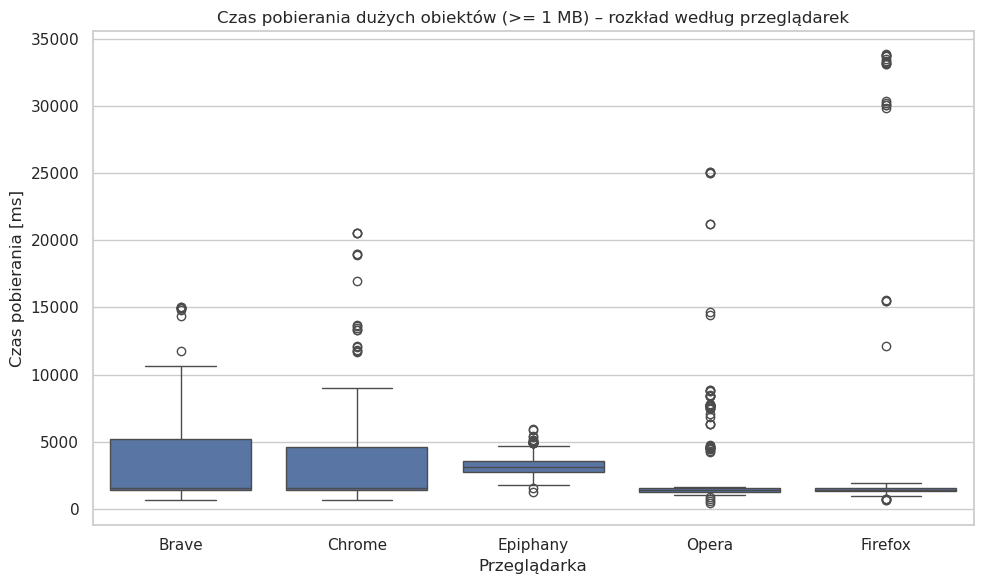

In [161]:
if not df_large.empty:
    duration_stats_all = (
        df_large.groupby(['browser', 'attempt'])['duration_ms']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_large, x='browser', y='duration_ms', showfliers=True)
    plt.xlabel('Przeglądarka')
    plt.ylabel('Czas pobierania [ms]')
    plt.title('Czas pobierania dużych obiektów (>= 1 MB) – rozkład według przeglądarek')
    plt.tight_layout()
    plt.show()
else:
    print("Brak dużych obiektów do wyświetlenia czasu pobierania.")


### Boxplot czasu pobierania dużych obiektów (>= 1 MB) – szczegółowo per przeglądarka i próba
Poniższy wykres przedstawia rozkład czasu pobierania dużych plików (o rozmiarze co najmniej 1 MB) dla każdej przeglądarki i każdej próby osobno. Każdy boxplot pokazuje medianę, rozrzut oraz wartości odstające dla czasu pobierania w danej konfiguracji.
Dzięki temu można porównać, jak różne przeglądarki i różne próby radzą sobie z pobieraniem dużych plików, a także ocenić stabilność i powtarzalność wyników. Wykres pozwala zidentyfikować przeglądarki, które pobierają duże pliki szybciej i bardziej stabilnie oraz te, które wykazują większą zmienność lub opóźnienia.

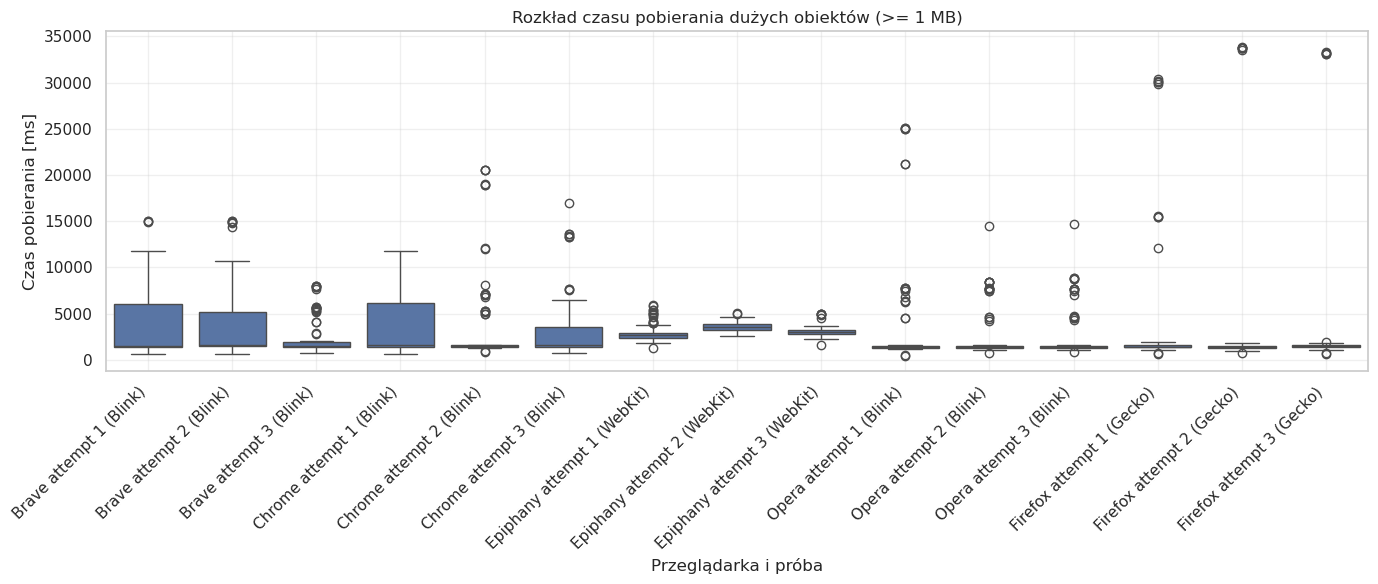

In [162]:
if not df_large.empty:
    duration_stats = (
        df_large
        .groupby(['browser', 'attempt'])['duration_ms']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .reset_index()
    )

    df_large_plot = df_large.copy()
    df_large_plot['browser_attempt_label'] = (
        df_large_plot['browser'].str.capitalize() + ' attempt ' +
        df_large_plot['attempt'].astype(str) + ' (' +
        df_large_plot['engine'] + ')'
    )

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_large_plot, x='browser_attempt_label', y='duration_ms', showfliers=True)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Czas pobierania [ms]')
    plt.xlabel('Przeglądarka i próba')
    plt.title('Rozkład czasu pobierania dużych obiektów (>= 1 MB)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Brak obiektów >= 1 MB do porównania między przeglądarkami.")


### Statystyki czasu pobierania dużych obiektów – porównanie przeglądarek
W tej komórce prezentowane są statystyki opisowe dotyczące czasu pobierania dużych plików (>= 1 MB) dla każdej przeglądarki osobno. Zobaczysz liczbę pobranych obiektów, średni, medianę, minimalny i maksymalny czas pobierania dla każdej przeglądarki.
Dzięki temu można łatwo porównać wydajność przeglądarek pod kątem pobierania dużych plików oraz zidentyfikować te, które radzą sobie najlepiej lub najgorzej w tym zadaniu.

In [163]:
if not df_large.empty:
    browser_cmp = (
        df_large.groupby('browser')['duration_ms']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .reset_index()
    )
    print("\nPorównanie między przeglądarkami (obiekty >= 1 MB):")
    display(browser_cmp)
else:
    print("Brak obiektów >= 1 MB do porównania między przeglądarkami.")



Porównanie między przeglądarkami (obiekty >= 1 MB):


,browser,count,mean,median,min,max
0,Brave,276,3405.902174,1565.0,674.0,15039.0
1,Chrome,276,3472.833333,1534.5,636.0,20503.0
2,Epiphany,276,3227.724638,3096.5,1248.0,5973.0
3,Firefox,276,3413.507246,1447.5,663.0,33863.0
4,Opera,276,2832.373188,1419.0,460.0,25033.0


### Boxplot czasu pobierania dużych obiektów – porównanie przeglądarek
Poniższy wykres przedstawia rozkład czasu pobierania dużych plików (o rozmiarze co najmniej 1 MB) dla każdej przeglądarki osobno. Boxplot pokazuje medianę, rozrzut oraz wartości odstające dla czasu pobierania (w milisekundach).
Dzięki temu można porównać, która przeglądarka pobiera duże pliki najszybciej, a także ocenić stabilność i zmienność czasu transferu pomiędzy różnymi przeglądarkami. Wykres pozwala zidentyfikować przeglądarki, które radzą sobie najlepiej z dużymi obiektami oraz te, które wykazują większą zmienność lub opóźnienia.

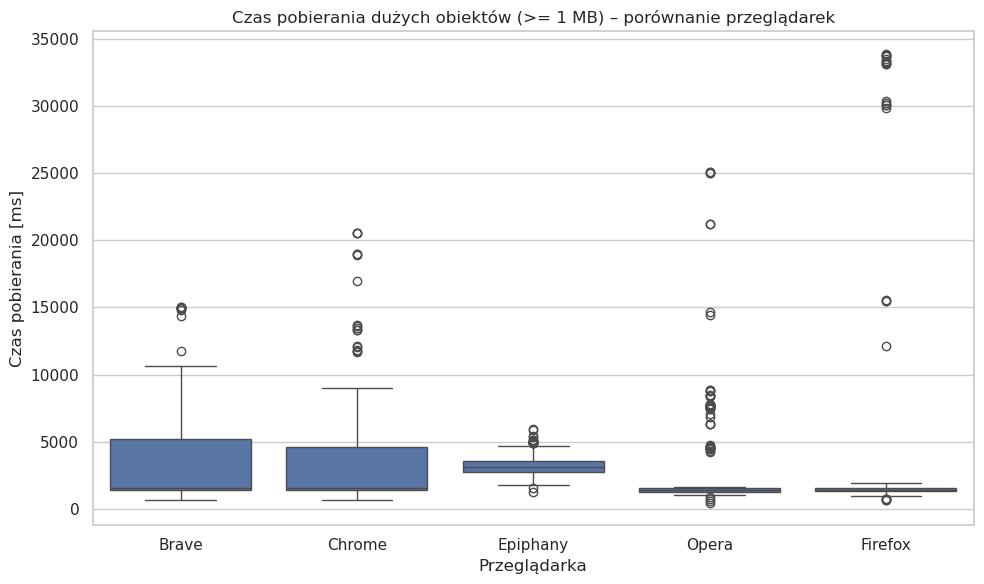

In [164]:
if not df_large.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_large, x='browser', y='duration_ms', showfliers=True)
    plt.xlabel('Przeglądarka')
    plt.ylabel('Czas pobierania [ms]')
    plt.title('Czas pobierania dużych obiektów (>= 1 MB) – porównanie przeglądarek')
    plt.tight_layout()
    plt.show()


### Boxplot prędkości pobierania dużych obiektów (>= 1 MB)
Poniższy wykres przedstawia rozkład prędkości pobierania dużych plików (o rozmiarze co najmniej 1 MB) dla każdej przeglądarki osobno. Boxplot pokazuje medianę, rozrzut oraz wartości odstające dla prędkości pobierania (w KB/s).

Dzięki temu można porównać, która przeglądarka pobiera duże pliki najszybciej, a także ocenić stabilność i zmienność prędkości transferu pomiędzy różnymi przeglądarkami.

,browser,attempt,count,mean,median,min,max
0,Brave,1,92,10539.195676,14989.415161,1457.780854,24423.277274
1,Brave,2,92,10485.795518,13851.286237,1395.182643,25945.847994
2,Brave,3,92,12565.560813,14512.526241,2791.965331,29505.360383
3,Chrome,1,92,10424.096545,13980.553459,1862.061770,27011.174203
4,Chrome,2,92,12461.665468,15012.016240,1062.815598,21649.083358
5,Chrome,3,92,11718.512808,13983.432129,1315.097488,21998.698368
6,Epiphany,1,92,7984.765702,8197.601654,3552.985669,12709.183913
7,Epiphany,2,92,6169.105616,6216.476641,4275.424520,7966.891154
8,Epiphany,3,92,7266.847397,7453.292333,4331.749462,10115.472910
9,Firefox,1,92,14116.367267,15167.661252,687.583837,27410.532962


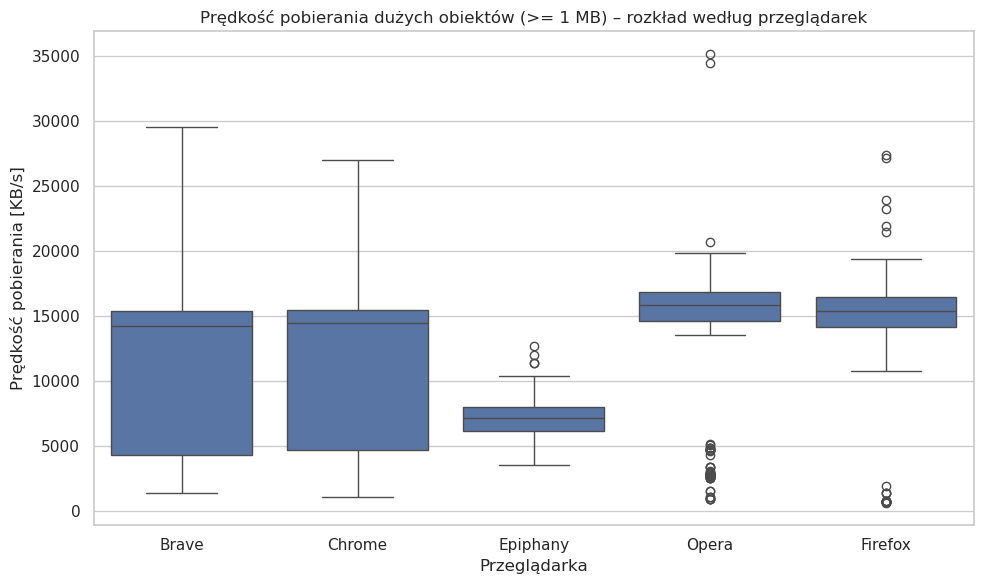

In [165]:
df_speed = df_large[df_large['speed_kb_per_s'].notna()].copy()

if not df_speed.empty:
    speed_stats = (
        df_speed.groupby(['browser', 'attempt'])['speed_kb_per_s']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .reset_index()
    )
    display(speed_stats)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_speed, x='browser', y='speed_kb_per_s', showfliers=True)
    plt.xlabel('Przeglądarka')
    plt.ylabel('Prędkość pobierania [KB/s]')
    plt.title('Prędkość pobierania dużych obiektów (>= 1 MB) – rozkład według przeglądarek')
    plt.tight_layout()
    plt.show()


# 4. Analiza przerw czasowych (Time Gaps)
W tej sekcji analizujemy przerwy czasowe (gaps) pomiędzy pobieraniem kolejnych obiektów w ramach tego samego połączenia TCP (portu klienta). Przerwy te mogą wynikać z ograniczeń przeglądarki, serwera lub sieci, a ich długość i częstotliwość pozwalają lepiej zrozumieć, jak przeglądarki zarządzają transferem danych.

### Histogram przerw czasowych między pobieraniami
Na poniższym wykresie zobaczysz histogram długości przerw czasowych (gaps) pomiędzy pobieraniem kolejnych obiektów w ramach tego samego połączenia TCP. Wartości na osi X oznaczają długość przerwy w milisekundach, a oś Y pokazuje liczbę wystąpień dla danej długości przerwy.

Histogram pozwala ocenić, czy typowe przerwy są krótkie, czy zdarzają się dłuższe okresy bez transferu. Dzięki temu można zidentyfikować, czy przeglądarki efektywnie wykorzystują połączenia oraz czy występują opóźnienia pomiędzy kolejnymi pobraniami.

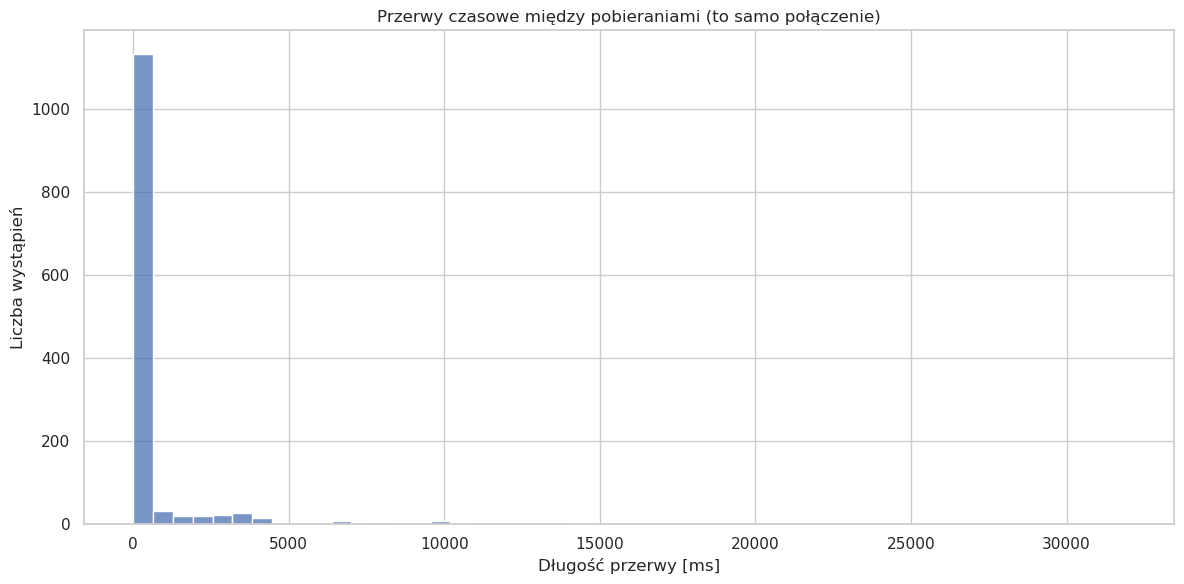

In [166]:
gaps = []
for (b, a, port), g in df_complete.groupby(['browser', 'attempt', 'client_port']):
    g_sorted = g.sort_values('first_timestamp').reset_index(drop=True)
    for i in range(1, len(g_sorted)):
        prev_end = g_sorted.loc[i-1, 'last_timestamp']
        curr_start = g_sorted.loc[i, 'first_timestamp']
        gap_ms = (curr_start - prev_end).total_seconds() * 1000.0
        if gap_ms > 0:
            gaps.append((b, a, gap_ms))

gaps_df = pd.DataFrame(gaps, columns=['browser', 'attempt', 'gap_ms'])

if not gaps_df.empty:
    gaps_stats = (
        gaps_df.groupby(['browser', 'attempt'])['gap_ms']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .reset_index()
    )

    plt.figure(figsize=(12, 6))
    sns.histplot(gaps_df['gap_ms'], bins=50, kde=False)
    plt.title('Przerwy czasowe między pobieraniami (to samo połączenie)')
    plt.xlabel('Długość przerwy [ms]')
    plt.ylabel('Liczba wystąpień')
    plt.tight_layout()
    plt.show()
else:
    print("Nie znaleziono dodatnich przerw czasowych – brak danych do wykresu.")


### Boxplot długości przerw według przeglądarki
Poniższy wykres przedstawia rozkład długości przerw czasowych pomiędzy pobieraniem obiektów dla każdej przeglądarki osobno. Boxplot pokazuje medianę, rozrzut oraz wartości odstające dla długości przerw.

Dzięki temu można porównać, która przeglądarka efektywniej zarządza transferem i szybciej rozpoczyna kolejne pobrania. Wykres pozwala zidentyfikować różnice w strategii pobierania zasobów pomiędzy przeglądarkami.

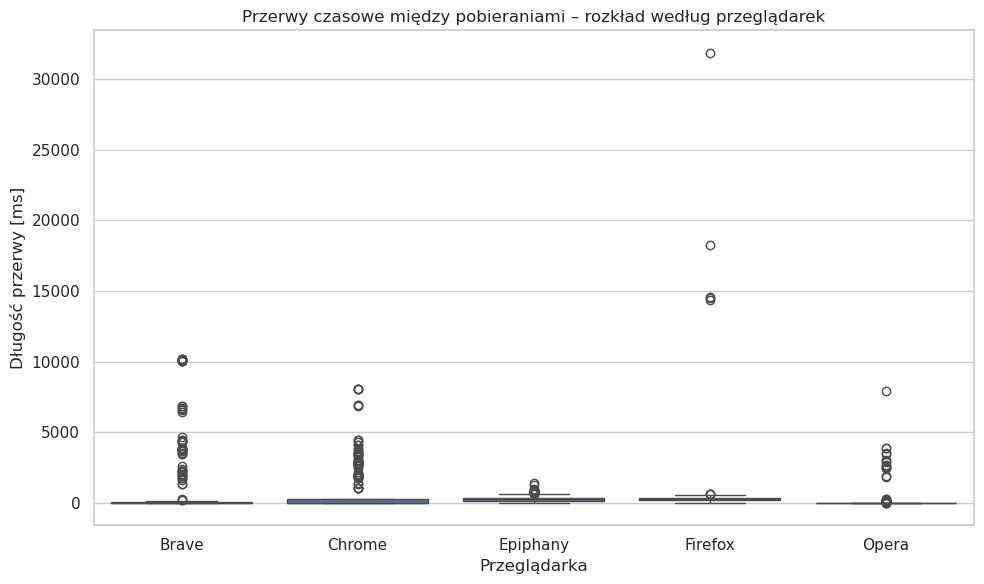

In [167]:
if not gaps_df.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=gaps_df, x='browser', y='gap_ms', showfliers=True)
    plt.xlabel('Przeglądarka')
    plt.ylabel('Długość przerwy [ms]')
    plt.title('Przerwy czasowe między pobieraniami – rozkład według przeglądarek')
    plt.tight_layout()
    plt.show()


# **Podsumowanie analizy i wnioski**


W niniejszym dokumencie przeanalizowano szczegółowo zachowanie różnych przeglądarek podczas pobierania dużych plików graficznych z serwera HTTP. Przeprowadzono szereg testów, w których oceniano m.in.:

- **Czas ładowania strony**

- **Liczbę równoczesnych pobrań**

- **Rozkład silników renderujących**

- **Prędkość transferu**

- **Przerwy czasowe**

- **Strategię zarządzania połączeniami TCP**



Wyniki pokazują wyraźne różnice w wydajności i sposobie pobierania zasobów pomiędzy przeglądarkami:

- Przeglądarki oparte na silniku **Blink** (Chrome, Brave, Opera) wykazują wysoką równoległość pobrań i stabilne czasy transferu.
- **Firefox (Gecko)** oraz **Epiphany (WebKit)** prezentują odmienne strategie, przy czym Epiphany wyróżnia się nietypowym zachowaniem.


> **Ważna obserwacja:**
> Przeglądarka **Epiphany** podczas renderowania strony pobiera ponad **10 GB pamięci RAM**, co prowadzi do jej awarii (crash) przy próbie załadowania dużej liczby plików. To wskazuje na poważne problemy z zarządzaniem pamięcią w tym silniku i czyni Epiphany niezalecaną do obsługi stron z dużą ilością ciężkich zasobów.


**Wnioski z analizy:**

- Wyniki mogą być wykorzystane do optymalizacji serwerów WWW oraz wyboru przeglądarki do zadań wymagających intensywnego pobierania.
- Przeglądarki Blink są najbardziej efektywne i stabilne w testowanych warunkach.
- Epiphany nie nadaje się do obsługi stron z dużą ilością ciężkich plików ze względu na krytyczne problemy z pamięcią.
- Analiza pozwala na dalsze badania nad efektywnością silników renderujących i strategią pobierania zasobów.


---